<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep convolutional net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an IPython notebook via Learning Suite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 20% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracies
* 10% Reach 85% validation accuracy from parts 1-3
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**

* Watch tutorial

**DONE:**

In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [ ]:
# Use the dataset class you created in lab2
class FashionMNISTProcessedDataset(Dataset):
    def __init__(self, root, train=True):
        self.data = datasets.FashionMNIST(root,
                                          train=train,
                                          transform=transforms.ToTensor(),
                                          download=True)
    def __getitem__(self, i):
        x,y = self.data[i]
        return x,y

    def __len__(self):
        return len(self.data)


___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropyLoss function. Do not use PyTorch's implementation of cross entropy loss (F.cross_entropy or nn.CrossEntropyLoss) for your re-implementation of cross entropy loss. You may use PyTorch's functional implemenation of 2D convolution in your Conv2D module.

**TODO:**

* CrossEntropyLoss 
* Conv2D

**DONE:**





### Personal Notes

Cross Entropy Loss is meant to measure the performance of a classification model whose output is a probability between 0 and 1.


The way this works is that the objective function is given two inputs from the data loader: y_hat and y_truth. y_hat is of size (batch, class) and y_truth is shape (batch).

What the loss function needs to do is to softmax all of the data for each batch using the formula

$$ L_i = -\log\left(\frac{e^{s_i}}{\sum_i e^{s_i}}\right) = -\left( \underbrace{\log(e^{s_i}}_a) - \underbrace{\log(\sum_i e^{s_i}}_b) \right)$$



In [ ]:
class CrossEntropyLoss(nn.Module):
    #start around 50 minutes in video for tips on this
    def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean'):
        super(CrossEntropyLoss, self).__init__()

    def forward(self, input:torch.Tensor, target:torch.Tensor) -> torch.Tensor:
        """
        input is yhat ((batch, class, score))
        target is y_truth (list of indexes)
        """
        #raise prediction scores to e and normlize each member of batch
        Li = -torch.log(torch.exp(input)) + torch.logsumexp(input, 1, keepdim=True)

        # numerically unstable way I think...
        # temp = torch.exp(input)/torch.sum(torch.exp(input), 1, keepdims=True)
        # test = -torch.log(temp)
        # assert torch.allclose(Li, test)

        #extract normalized prediction for each batch member according to y_truth index
        batch_idx = torch.arange(input.shape[0]) #[0,1,2,...,N]
        #not sure what to do here...
        losses = Li[batch_idx, target]
        # pdb.set_trace()

        return losses.mean() #defaults to mean?


### Personal notes

Output of the convolutional 2d layer with input of $(N, C_{in}, H_{in}, W_{in})$ is $(N, C_{out}, H_{out}, W_{out})$ according to [pytorch docs.](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#:~:text=output.%20Default%3A%20True-,Shape%3A,-Input%3A)

So in order to put in a FC layer near the end to hopefully learn interconnections between larger pixels, it needs to accept an input of shape $(N, C_{out}, H_{out}, W_{out})$.

In [ ]:
class ConvNetwork(nn.Module):
    def __init__(self, dataset, weight_init):
        super(ConvNetwork, self).__init__()
        x,y = dataset[0]
        #input comes in as shape batch x channel x width x height
        channel,height,width = x.size()
        output = 10

        print('c,h,w:', channel, height, width)
        #changed channel size to 8 instead of 10 per Connor's slack suggestion
        """output of 1st conv2d should be 
        (N, Cout, Hout, Wout) = (N, Cout, height, width)
        where
        (height + 2(1) - 1(3-1) - 1)/1 + 1 = height = Hout,
        (width + 2(1) - 1(3-1) - 1)/1 + 1 = width = Wout, and
        Cout is given by out_channels arg"""
        self.net  = nn.Sequential(
            Conv2d(channel,
                   8,
                   kernel_size=(3,3),
                   padding=(1,1),
                   initialize=weight_init),
            nn.ReLU(),
            # nn.Linear(in_features=8*height*width,
            #           out_features=8*height*width),
            # nn.ReLU(),
            Conv2d(8,
                   24,
                   kernel_size=(3,3),
                   padding=(1,1),
                   initialize=weight_init),
            nn.ReLU(),
            Conv2d(24,
                   72,
                   kernel_size=(3,3),
                   padding=(1,1),
                   initialize=weight_init),
            nn.ReLU(),   
            Conv2d(72,
                   216,
                   kernel_size=(3,3),
                   padding=(1,1),
                   initialize=weight_init),
            nn.ReLU(),                
            Conv2d(216, output, (28,28), padding=(0,0), initialize=weight_init),
        )

    def forward(self, x):
        return self.net(x).squeeze(2).squeeze(2)


___

### Part 2
Implement three initialization strategies: Xe initialization
(sometimes called Xavier), orthogonal initialization, and uniform random initialization.
You can specify which strategy you want to use with a parameter.



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**
* Parameterize custom Conv2D for different initilization strategies
* Xe
* Orthogonal
* Uniform

**DONE:**

In [ ]:
class Conv2d(nn.Module):
    def __init__(self, 
                 n_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,
                 groups=1,
                 bias=True,
                 initialize=None):
        
        #make everything in init a member variable
        self.__dict__.update(locals()) #merge dictionary of all currently in scope vars with whatever is already there

        super(Conv2d, self).__init__()

        # (out, in, kernel_size, kernel_size)
        self.weight = Parameter(torch.Tensor(self.out_channels,
                                   self.n_channels,
                                   kernel_size[0],
                                   kernel_size[1]))
        self.bias = Parameter(torch.Tensor(self.out_channels))


        #initialize tensors because the weights are just trash in memory. This will 
        # blow up the loss calculation on the first optimization step. Need to also 
        # make sure that the weights are the correct dtype (float32 for pytorch)

        #TODO: uniform, orthogonal, and Xe 
        if initialize == "orth":
            X = np.random.random((out_channels, self.n_channels*kernel_size[0]*kernel_size[1]))
            U, _, Vt = np.linalg.svd(X, full_matrices=False)
            W = Vt.reshape((out_channels, self.n_channels, kernel_size[0], kernel_size[1]))
            with torch.no_grad():
                self.weight = Parameter(torch.from_numpy(W).float())
                self.bias.data.uniform_(0,0)

        elif initialize == "xe":
            self.weight.data = torch.normal(mean=0.0,
                                            std=(2./self.n_channels)**2,
                                            size=(out_channels, self.n_channels, kernel_size[0], kernel_size[1]))
            self.bias.data.uniform_(0,0)            

        elif initialize == "uni":
            self.weight.data.uniform_(-.1,.1)
            self.bias.data.uniform_(0,0)
        else:
            raise ValueError("Forgot initialization")

    def forward(self, x):
        return F.conv2d(x,
                        self.weight,
                        self.bias,
                        self.stride,
                        self.padding,
                        self.dilation,
                        self.groups)
        
    def extra_repr(self):
        # function to add info when you print out model()
        return 'extra information'
        

In [ ]:
# Initialize Datasets
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist')
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

def run_experiment(weight_init):

    # Initialize DataLoaders
    train_loader = DataLoader(train_dataset,
                            batch_size=42,
                            pin_memory=True,
                            shuffle=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=42,
                            pin_memory=True)

    # Initialize Model
    # uni, xe, orth are options for weight_init
    model = ConvNetwork(train_dataset, weight_init=weight_init)
    model = model.cuda()

    #total num of params
    num_params = sum([torch.numel(layer) for layer in model.parameters()])
    #size of each individual params for checking
    print("Num model params: ", num_params)
    for p in model.parameters():
        print(p.shape)

    # Initialize Objective and Optimizer and other parameters
    objective = torch.nn.CrossEntropyLoss()
    my_objective = CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    losses = []
    validations = []
    training_accuracies = []
    val_accuracies = []

    # Run your training and validation loop and collect stats
    for epoch in range(2):
        loop = tqdm(total=len(train_loader), position=0, leave=False)

        for batch, (x, y_truth) in enumerate(train_loader):
            x,y_truth = x.cuda(), y_truth.cuda()
            optimizer.zero_grad()
            y_hat = model(x)

            # pdb.set_trace()
            loss = objective(y_hat, y_truth)
            loss_test = my_objective(y_hat, y_truth)
            #make sure losses are the same
            assert torch.allclose(loss, loss_test)

            loss.backward()
            losses.append(loss.item())

            # testing my loss function
            my_loss = my_objective(y_hat, y_truth)
            
            # pdb.set_trace()
            train_accuracy = (y_hat.argmax(1) == y_truth).float().mean()
            training_accuracies.append(train_accuracy.item())
            loop.set_description('epoch:{}, batch:{}, loss:{:.4f}, accuracy:{:.3f}'.format(epoch,
                                                                                        batch,
                                                                                        losses[-1],
                                                                                        train_accuracy))
            loop.update(1)

            optimizer.step()

            #check intermediate validation loss and prediction accuracy
            if batch % 50 == 0:
                val = np.mean([objective(model(x_val.cuda()), y_val.cuda()).item()
                            for x_val, y_val in val_loader])
                validations.append((len(losses), val))
                val_accuracy = ([(model(x_val.cuda()).argmax(1) == y_val.cuda()).float().mean().item() for x_val,y_val in val_loader])
                val_accuracies.append((len(losses), val_accuracy))

    return losses, validations, training_accuracies, val_accuracies

In [ ]:
# uni experiment
uni_losses, uni_vals, uni_acc_train, uni_acc_val = run_experiment(weight_init='uni')

c,h,w: 1 28 28
Num model params:  1851090
torch.Size([8, 1, 3, 3])
torch.Size([8])
torch.Size([24, 8, 3, 3])
torch.Size([24])
torch.Size([72, 24, 3, 3])
torch.Size([72])
torch.Size([216, 72, 3, 3])
torch.Size([216])
torch.Size([10, 216, 28, 28])
torch.Size([10])


In [ ]:
# orth experiment
orth_losses, orth_vals, orth_acc_train, orth_acc_val = run_experiment(weight_init='orth')

c,h,w: 1 28 28
Num model params:  1851090
torch.Size([8, 1, 3, 3])
torch.Size([8])
torch.Size([24, 8, 3, 3])
torch.Size([24])
torch.Size([72, 24, 3, 3])
torch.Size([72])
torch.Size([216, 72, 3, 3])
torch.Size([216])
torch.Size([10, 216, 28, 28])
torch.Size([10])


In [ ]:
# xe experiment
xe_losses, xe_vals, xe_acc_train, xe_acc_val = run_experiment(weight_init='xe')

c,h,w: 1 28 28
Num model params:  1851090
torch.Size([8, 1, 3, 3])
torch.Size([8])
torch.Size([24, 8, 3, 3])
torch.Size([24])
torch.Size([72, 24, 3, 3])
torch.Size([72])
torch.Size([216, 72, 3, 3])
torch.Size([216])
torch.Size([10, 216, 28, 28])
torch.Size([10])



___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

Once you've experimented with multiple network setups and the different initialization strategies, plot the best-performing experiments with each initialization strategy. You should be able to exceed 85% accuracy on the validation set in at least one of the plotted experiments.

**TODO:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time for each initialization strategy (w/ accurate graph title and axes lables)
* Plot experiment results with 85% or better validation accuracy
* Print out number of parameters in the model 

**DONE:**


Max validation accuracy:  0.8926081116229421


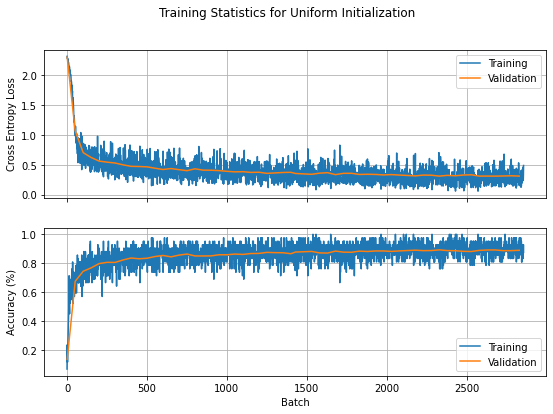

In [ ]:
# Go back up and try a few different networks and initialization strategies

# Plot training and validation loss for uniform initialization
batches = [data[0] for data in uni_vals]
vals = [data[1] for data in uni_vals]
fig,ax = plt.subplots(2, sharex=True, figsize=(9,6))
fig.suptitle("Training Statistics for Uniform Initialization")
ax[0].plot(uni_losses)
ax[0].plot(batches, vals)
ax[0].set(ylabel='Cross Entropy Loss')
ax[0].grid()
ax[0].legend(["Training", "Validation"])

# Plot training and validation accuracy for uniform initialization
ax[1].plot(uni_acc_train)
acc_vals = [np.mean(data[1]) for data in uni_acc_val]
ax[1].plot(batches, acc_vals)
ax[1].grid()
ax[1].set(ylabel='Accuracy (%)', xlabel="Batch")
ax[1].legend(["Training", "Validation"])

print("Max validation accuracy: ", np.max(acc_vals))

Max validation accuracy:  0.8983861549628829


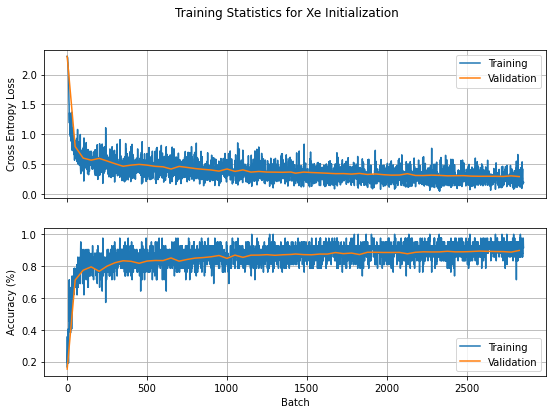

In [ ]:
# Plot training and validation loss for Xe initialization
batches = [data[0] for data in xe_vals]
vals = [data[1] for data in xe_vals]
fig,ax = plt.subplots(2, sharex=True, figsize=(9,6))
fig.suptitle("Training Statistics for Xe Initialization")
ax[0].plot(xe_losses)
ax[0].plot(batches, vals)
ax[0].set(ylabel='Cross Entropy Loss')
ax[0].grid()
ax[0].legend(["Training", "Validation"])

# Plot training and validation accuracy for Xe initialization
ax[1].plot(xe_acc_train)
acc_vals = [np.mean(data[1]) for data in xe_acc_val]
ax[1].plot(batches, acc_vals)
ax[1].grid()
ax[1].set(ylabel='Accuracy (%)', xlabel="Batch")
ax[1].legend(["Training", "Validation"])

print("Max validation accuracy: ", np.max(acc_vals))

Max validation accuracy:  0.905459276053696


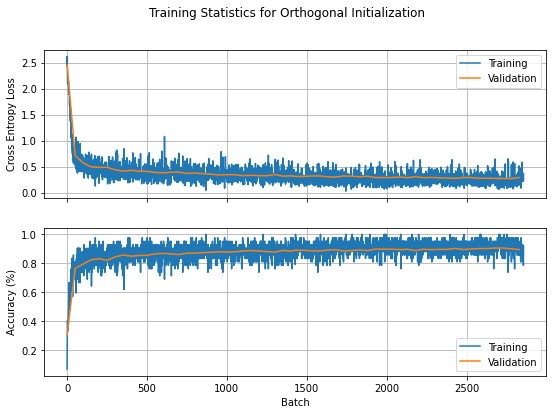

In [ ]:
# Plot training and validation loss for orthogonal initialization
batches = [data[0] for data in orth_vals]
vals = [data[1] for data in orth_vals]
fig,ax = plt.subplots(2, sharex=True, figsize=(9,6))
fig.suptitle("Training Statistics for Orthogonal Initialization")
ax[0].plot(orth_losses)
ax[0].plot(batches, vals)
ax[0].set(ylabel='Cross Entropy Loss')
ax[0].grid()
ax[0].legend(["Training", "Validation"])

# Plot training and validation accuracy for orthogonal initialization
ax[1].plot(orth_acc_train)
acc_vals = [np.mean(data[1]) for data in orth_acc_val]
ax[1].plot(batches, acc_vals)
ax[1].grid()
ax[1].set(ylabel='Accuracy (%)', xlabel="Batch")
ax[1].legend(["Training", "Validation"])

print("Max validation accuracy: ", np.max(acc_vals))

___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **(out_channels=10, kernel_size=(3, 3), padding=(0, 0))**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernel_size=(3, 3), padding=(1, 1))**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **(out_channels=65, kernel_size=(3, 3), padding=(2, 2))**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **(out_channels=7, kernel_size=(3, 3), padding=(6, 6))**

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **(out_channels=10, kernel_size=(5, 5), padding=(1, 1))**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5, 5), padding=(2, 2))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5, 5), padding=(3, 3))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5, 5), padding=(9, 9))**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **(out_channels=10, kernel_size=(5, 3), padding=(1, 0))**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5, 3), padding=(2, 1))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5, 3), padding=(3, 2))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5, 3), padding=(9, 8))**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

** since smallest padding is 0, I presume this means find kernel that does NOT require any padding **

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **(out_channels=10, kernel_size=(2, 4), padding=(0, 0))**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernel_size=(1, 1), padding=(0, 0))**

**TODO:**

* Answer all the questions above 

**DONE:**


In [ ]:
# Write some test code for checking the answers for these problems (example shown in the video)
def calc_conv_setting(cin, hin, win, cout, hout, wout, kernel_size, stride=(1,1), dilation=(1,1)):
    #use pytorch's equations https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    p0 = (((hout - 1)*stride[0]) - hin + dilation[0]*(kernel_size[0] - 1) + 1)/2
    p1 = (((wout - 1)*stride[1]) - win + dilation[1]*(kernel_size[1] - 1) + 1)/2
    padding = (p0,p1)
    print("Settings:\ncout:{}\npadding:{}\nkernel_size:{}\n\n".format(cout, padding,kernel_size))

def calc_kernel(cin, hin, win, cout, hout, wout, padding = (0,0), stride=(1,1), dilation=(1,1)):
    #use pytorch's equations https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    k0 = (((hout - 1)*stride[0]) - hin -2*padding[0] - dilation[0] + 1)/-dilation[0]
    k1 = (((wout - 1)*stride[1]) - win -2*padding[1] - dilation[1] + 1)/-dilation[1]
    kernel_size = (k0,k1)
    print("Settings:\ncout:{}\npadding:{}\nkernel_size:{}\n\n".format(cout, padding,kernel_size))

In [ ]:
kernel_size = (3,3)
calc_conv_setting(3,10,10,10,8,8,kernel_size)
calc_conv_setting(3,10,10,22,10,10,kernel_size)
calc_conv_setting(3,10,10,65,12,12,kernel_size)
calc_conv_setting(3,10,10,7,20,20,kernel_size)

#last case
c = nn.Conv2d(3,7,kernel_size=(3,3), padding=(6,6))
c(torch.zeros(1,3,10,10)).size()

Settings:
cout:10
padding:(0.0, 0.0)
kernel_size:(3, 3)


Settings:
cout:22
padding:(1.0, 1.0)
kernel_size:(3, 3)


Settings:
cout:65
padding:(2.0, 2.0)
kernel_size:(3, 3)


Settings:
cout:7
padding:(6.0, 6.0)
kernel_size:(3, 3)




torch.Size([1, 7, 20, 20])

In [ ]:
kernel_size = (5,5)
calc_conv_setting(3,10,10,10,8,8,kernel_size)
calc_conv_setting(3,10,10,100,10,10,kernel_size)
calc_conv_setting(3,10,10,23,12,12,kernel_size)
calc_conv_setting(3,10,10,5,24,24,kernel_size)


#last case
c = nn.Conv2d(3,5,kernel_size=(5,5), padding=(9,9))
c(torch.zeros(1,3,10,10)).size()

Settings:
cout:10
padding:(1.0, 1.0)
kernel_size:(5, 5)


Settings:
cout:100
padding:(2.0, 2.0)
kernel_size:(5, 5)


Settings:
cout:23
padding:(3.0, 3.0)
kernel_size:(5, 5)


Settings:
cout:5
padding:(9.0, 9.0)
kernel_size:(5, 5)




torch.Size([1, 5, 24, 24])

In [ ]:
kernel_size = (5,3)
calc_conv_setting(3,10,10,10,8,8,kernel_size)
calc_conv_setting(3,10,10,100,10,10,kernel_size)
calc_conv_setting(3,10,10,23,12,12,kernel_size)
calc_conv_setting(3,10,10,5,24,24,kernel_size)


#last case
c = nn.Conv2d(3,5,kernel_size=(5,3), padding=(9,8))
c(torch.zeros(1,3,10,10)).size()

Settings:
cout:10
padding:(1.0, 0.0)
kernel_size:(5, 3)


Settings:
cout:100
padding:(2.0, 1.0)
kernel_size:(5, 3)


Settings:
cout:23
padding:(3.0, 2.0)
kernel_size:(5, 3)


Settings:
cout:5
padding:(9.0, 8.0)
kernel_size:(5, 3)




torch.Size([1, 5, 24, 24])

In [ ]:
calc_kernel(3,10,10,10,9,7)
calc_kernel(3,10,10,22,10,10)


#last case
c = nn.Conv2d(3,22,kernel_size=(1,1), padding=(0,0))
c(torch.zeros(1,3,10,10)).size()

Settings:
cout:10
padding:(0, 0)
kernel_size:(2.0, 4.0)


Settings:
cout:22
padding:(0, 0)
kernel_size:(1.0, 1.0)




torch.Size([1, 22, 10, 10])